In [1]:
# install dependencies
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install lxml
# %pip install scipy
# %pip install mplsoccer
# %pip install highlight-text
# %pip install ipywidgets
# %pip install ipympl

In [2]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from mplsoccer import PyPizza, add_image, FontManager
from highlight_text import fig_text

# %matplotlib ipympl
# %matplotlib widget
import ipywidgets as widgets

In [3]:
filepath = 'fm24-data/data/v2/top6_leagues_cdm.html'

dfs = pd.read_html(filepath, encoding='utf8')
assert len(dfs) > 0 
df = dfs[0]
df.head()

,Rec,Inf,Name,Age,Weight,Height,Nat,Preferred Foot,Position,Club,...,K Hdrs/90,Pres A/90,Pres C/90,Sprints/90,Dist/90,Distance,Gl Mst,Tgls/90,Tcon/90,Av Rat
0,- - -,NaN,Esteban Fernández,23,77 kg,183 cm,ARG,Right,"DM, M (C), AM (RC)",Man City,...,0.00,10.30,2.29,13.35,0.0mi,47.8mi,0,6.11,3.11,6.98
1,- - -,Sct,Archie Gray,26,77 kg,182 cm,ENG,Right,"DM, M (C)",FC Bayern,...,0.16,10.03,2.78,11.96,0.0mi,304.4mi,0,7.96,2.65,7.08
2,- - -,nEU,Enzo Fernández,31,70 kg,178 cm,ARG,Right,"DM, M/AM (C)",AC Milan,...,0.07,11.28,2.88,13.01,0.0mi,360.3mi,0,4.75,3.92,7.19
3,- - -,NaN,Sebastián Ahlin,24,73 kg,178 cm,SWE,Right,"DM, M (LC), AM (C)",Barcelona,...,0.00,8.94,2.33,11.89,0.0mi,108.4mi,0,6.02,1.43,6.66
4,- - -,Inj,Sonhy Pancrate,23,65 kg,170 cm,FRA,Left,"DM, M/AM (C)",Real San Sebastián,...,0.03,10.49,3.27,11.87,0.0mi,287.4mi,0,6.23,3.02,6.96


In [4]:
print("Number of players:", df.shape[0])
print("Number of fields:", df.shape[1])

Number of players: 827
Number of fields: 59


In [5]:
print(df.columns)

Index(['Rec', 'Inf', 'Name', 'Age', 'Weight', 'Height', 'Nat',
       'Preferred Foot', 'Position', 'Club', 'Division', 'Salary',
       'Transfer Value', 'Mins', 'Gls', 'xG', 'Ast', 'xA', 'Gls/90', 'xG/90',
       'NP-xG/90', 'Shot/90', 'Shot %', 'Conv %', 'Asts/90', 'xA/90',
       'Ps A/90', 'Pas %', 'Ps C/90', 'Pr passes/90', 'OP-KP/90',
       'OP-Crs A/90', 'OP-Cr %', 'OP-Crs C/90', 'Ch C/90', 'Drb/90',
       'Poss Won/90', 'Poss Lost/90', 'Tck R', 'K Tck/90', 'Tck/90', 'Blk/90',
       'Int/90', 'Clr/90', 'Fls', 'Aer A/90', 'Hdr %', 'Hdrs W/90',
       'Hdrs L/90', 'K Hdrs/90', 'Pres A/90', 'Pres C/90', 'Sprints/90',
       'Dist/90', 'Distance', 'Gl Mst', 'Tgls/90', 'Tcon/90', 'Av Rat'],
      dtype='object')


In [6]:
# data processing

# Copy dataframe
players = df.copy()

# 'Rec', 'Info' are not useful.
# 'Dist/90' are all 0.0s in the data, we are going to calculate Dist/90 from Dist (total distance)
players = players.drop(['Rec', 'Inf', 'Dist/90'], axis=1)

# Column categories
int_cols = ['Age', 'Mins', 'Gls', 'Ast']
percent_cols = ['Shot %', 'Conv %', 'Pas %', 'OP-Cr %', 'Tck R', 'Hdr %']
nonnumeric_cols = ['Name', 'Position', 'Club', 'Division', 'Nat', 'Preferred Foot', 'Salary', 'Transfer Value']

# Replace missing metrics with 0s
# Note: in Football Manager - ~ 0
players = players.replace('-', 0)

# Transform weight, height columns
players['Weight'] = players['Weight'].str.split().str[0]
players['Height'] = players['Height'].str.split().str[0]

# Transform salary column
players['Salary'] = players['Salary'].str.extract(r'£([\d,]+)\s*p/w')[0]
players['Salary'] = players['Salary'].str.replace(',', '').astype(float)

# Extract distance covered
players['Distance'] = players['Distance'].str.extract(r'([\d.]+)').astype(float)

# Convert % string to float
players[percent_cols] = players[percent_cols].apply(
    lambda x: pd.to_numeric(x.str.rstrip('%'), errors='coerce') / 100)

# Note: Replacing '-' with 0 interferes with how the values in percent columns are parsed, i.e "50%" and 0
# Therefore, we have to set the NaNs, originally '-' -> 0 -> np.nan, to 0
players[percent_cols] = players[percent_cols].replace(np.nan, 0)

# Convert to correct types
for col in players.columns:
    if col not in (nonnumeric_cols + int_cols):
        players[col] = pd.to_numeric(players[col], errors='coerce')
    if col in int_cols:
        players[col] = pd.to_numeric(players[col], errors='coerce').astype(int)

# Filter out players with 0 minutes
players = players[players['Mins'] > 0]

# Normalize Distance Covered and Fouls 
players['Dist/90'] = round(players['Distance'] / players['Mins'] * 90, 2)
players['Fls/90'] = round(players['Fls'] / players['Mins'] * 90, 2)

players = players.drop(['Distance', 'Fls'], axis=1)

# Display the first few rows
players.head()

,Name,Age,Weight,Height,Nat,Preferred Foot,Position,Club,Division,Salary,...,K Hdrs/90,Pres A/90,Pres C/90,Sprints/90,Gl Mst,Tgls/90,Tcon/90,Av Rat,Dist/90,Fls/90
0,Esteban Fernández,23,77,183,ARG,Right,"DM, M (C), AM (RC)",Man City,English Premier Division,63000.0,...,0.00,10.30,2.29,13.35,0,6.11,3.11,6.98,9.11,1.14
1,Archie Gray,26,77,182,ENG,Right,"DM, M (C)",FC Bayern,Bundesliga,275000.0,...,0.16,10.03,2.78,11.96,0,7.96,2.65,7.08,8.14,1.02
2,Enzo Fernández,31,70,178,ARG,Right,"DM, M/AM (C)",AC Milan,Italian Serie A,325000.0,...,0.07,11.28,2.88,13.01,0,4.75,3.92,7.19,7.99,1.06
3,Sebastián Ahlin,24,73,178,SWE,Right,"DM, M (LC), AM (C)",Barcelona,Spanish First Division,98000.0,...,0.00,8.94,2.33,11.89,0,6.02,1.43,6.66,8.42,1.09
4,Sonhy Pancrate,23,65,170,FRA,Left,"DM, M/AM (C)",Real San Sebastián,Spanish First Division,43500.0,...,0.03,10.49,3.27,11.87,0,6.23,3.02,6.96,8.11,1.02


In [7]:
# Utility functions

def categorize_positions(positions):
    
    pos_groups = set()
    s1 = positions.split(',')
    for p in s1:
        s2 = p.split()

        # edge case
        if s2[0] == 'GK':
            pos_groups.add('Goalkeepers')
            continue
        if s2[0] == 'DM':
            pos_groups.add('Midfielders')
            continue

        s3 = s2[0].split('/')   # D WB M AM ST
        s4 = s2[1].strip('()')  # R L C

        if 'D' in s3 and 'C' in s4:
            pos_groups.add('Centerbacks')
        if any(x in s3 for x in ['D', 'WB']) and any(x in s4 for x in ['R', 'L']):
            pos_groups.add('Fullbacks')
        if any(x in s3 for x in ['DM', 'M']) and 'C' in s4:
            pos_groups.add('Midfielders')
        if any(x in s3 for x in ['M', 'AM']) and any(x in s4 for x in ['R', 'L']) or \
            ('AM' in s3 and 'C' in s4):
            pos_groups.add('Att Mid/Wingers')
        if 'ST' in s3:
            pos_groups.add('Forwards')

    return list(pos_groups)

In [8]:
# Display CDMs for Bournemouth
players[players['Club'] == 'Bournemouth']

,Name,Age,Weight,Height,Nat,Preferred Foot,Position,Club,Division,Salary,...,K Hdrs/90,Pres A/90,Pres C/90,Sprints/90,Gl Mst,Tgls/90,Tcon/90,Av Rat,Dist/90,Fls/90
157,Manu Koné,30,79,185,FRA,Right,"DM, M/AM (C)",Bournemouth,English Premier Division,165000.0,...,0.16,10.19,2.72,18.99,0,6.96,2.80,6.96,8.72,2.24
268,João Neves,27,67,174,POR,Right,"DM, M/AM (C)",Bournemouth,English Premier Division,155000.0,...,0.06,11.03,2.68,13.53,0,5.95,4.97,6.96,8.21,1.10
314,Enoch Mastoras,25,72,174,NED,Right,"D (RC), WB (R), DM, M (R)",Bournemouth,English Premier Division,150000.0,...,0.11,9.50,3.46,18.36,1,6.63,2.15,7.04,8.51,0.95
414,Maxim Broekhof,22,73,177,NED,Either,"DM, M/AM (C)",Bournemouth,English Premier Division,125000.0,...,0.00,9.25,2.63,16.23,1,7.74,2.76,6.93,8.54,1.10
601,James Garner,31,77,182,ENG,Right,"D (L), DM, M (C)",Bournemouth,English Premier Division,120000.0,...,0.10,10.88,3.68,15.54,3,6.53,2.56,7.05,8.43,1.23


In [9]:
players.columns

Index(['Name', 'Age', 'Weight', 'Height', 'Nat', 'Preferred Foot', 'Position',
       'Club', 'Division', 'Salary', 'Transfer Value', 'Mins', 'Gls', 'xG',
       'Ast', 'xA', 'Gls/90', 'xG/90', 'NP-xG/90', 'Shot/90', 'Shot %',
       'Conv %', 'Asts/90', 'xA/90', 'Ps A/90', 'Pas %', 'Ps C/90',
       'Pr passes/90', 'OP-KP/90', 'OP-Crs A/90', 'OP-Cr %', 'OP-Crs C/90',
       'Ch C/90', 'Drb/90', 'Poss Won/90', 'Poss Lost/90', 'Tck R', 'K Tck/90',
       'Tck/90', 'Blk/90', 'Int/90', 'Clr/90', 'Aer A/90', 'Hdr %',
       'Hdrs W/90', 'Hdrs L/90', 'K Hdrs/90', 'Pres A/90', 'Pres C/90',
       'Sprints/90', 'Gl Mst', 'Tgls/90', 'Tcon/90', 'Av Rat', 'Dist/90',
       'Fls/90'],
      dtype='object')

In [10]:
# Only consider players who have played 5 or more in total minutes
players = players[players['Mins'] >= 450]

In [11]:
display(players.groupby('Division').count())

,Name,Age,Weight,Height,Nat,Preferred Foot,Position,Club,Salary,Transfer Value,...,K Hdrs/90,Pres A/90,Pres C/90,Sprints/90,Gl Mst,Tgls/90,Tcon/90,Av Rat,Dist/90,Fls/90
Division,,,,,,,,,,,,,,,,,,,,,
Bundesliga,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46,46,46
English Premier Division,73,73,73,73,73,73,73,73,73,73,...,73,73,73,73,73,73,73,73,73,73
Eredivisie,54,54,54,54,54,54,54,54,54,54,...,54,54,54,54,54,54,54,54,54,54
Italian Serie A,55,55,55,55,55,55,55,55,55,55,...,55,55,55,55,55,55,55,55,55,55
Ligue 1 Uber Eats,51,51,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51
Spanish First Division,66,66,66,66,66,66,66,66,66,66,...,66,66,66,66,66,66,66,66,66,66


In [12]:
# Add team possession

epl = {
    'Arsenal': 58,
    'Aston Villa': 54,
    'Blackburn': 39,
    'Bournemouth': 55,
    'Brentford': 54,
    'Brighton': 45,
    'Chelsea': 39,
    'Everton': 49,
    'Leeds': 53,
    'Liverpool': 56,
    'Man City': 56,
    'Man UFC': 50,
    'Newcastle': 53,
    'Norwich': 49,
    'Nottm Forest': 46,
    'Reading': 36,
    'Southampton': 54,
    'Sunderland': 47,
    'Tottenham': 49,
    'West Ham': 47
}

bundesliga = {
    '1. FC Köln': 50,
    'Augsburg': 49,
    'Bayer 04': 51,
    'Borussia Dortmund': 58,
    'Borussia M\'gladbach': 50,
    'Eintracht Frankfurt': 48,
    'FC Bayern': 61,
    'HSV': 45,
    'Hannover': 41,
    'Heidenheim': 44,
    'Hertha BSC': 46,
    'Mainz 05': 44,
    'RB Leipzig': 56,
    'SC Freiburg': 51,
    'SV Werder': 48,
    'Schalke 04': 50,
    'VfB Stuttgart': 46,
}


la_liga = {
    'A. Bilbao': 52,
    'A. Madrid': 58,
    'Alavés': 47,
    'Almería': 45,
    'Atlético Pamplona': 48,
    'Barcelona': 54,
    'Cádiz': 43,
    'Elche': 37,
    'Espanyol': 46,
    'Girona': 49,
    'Granada': 43,
    'Levante': 45,
    'R. Madrid': 65,
    'Real San Sebastián': 51,
    'Sevilla': 56,
    'Valencia': 50,
    'Villarreal': 56,
    'Zaragoza': 42
}

serie_a = {
    'AC Milan': 58,
    'AS Roma': 48,
    'Atalanta': 48,
    'Bologna': 52,
    'Brianza': 50,
    'Cagliari': 50,
    'Empoli': 44,
    'Fiorentina': 55,
    'Frosinone': 49,
    'Genoa': 42,
    'Hellas Verona': 39,
    'Inter': 55,
    'Juventus': 58,
    'Lazio': 54,
    'Modena': 43,
    'Parthenope': 55,
    'Pisa': 46,
    'Sampdoria': 46,
    'Sassuolo': 52,
    'Udinese': 48
}

eredivisie = {
    'AZ': 56,
    'Ajax': 60,
    'Excelsior': 42,
    'FC Eindhoven': 45,
    'FC Twente': 40,
    'FC Utrecht': 57,
    'FC Volendam': 43,
    'Feyenoord': 58,
    'Fortuna Sittard': 48,
    'Go Ahead Eagles': 45,
    'N.E.C. Nijmegen': 47,
    'PEC Zwolle': 47,
    'PSV': 58,
    'RKC Waalwijk': 47,
    'Sparta Rotterdam': 50,
    'Vitesse': 50,
    'sc Heerenveen': 51
}

ligue_1 = {
    'AJ Auxerre': 42,
    'AS Monaco': 58,
    'ASSE': 51,
    'Bordeaux': 42,
    'Grenoble': 47,
    'LOSC': 52,
    'Montpellier': 47,
    'OGC Nice': 51,
    'OL': 49,
    'Paris SG': 62,
    'RC Lens': 51,
    'Reims': 46,
    'Rennes': 51,
    'Strasbourg': 56,
    'Toulouse FC': 52,
    'Troyes': 41,
    'VAFC': 46
}


# Defensive Actions
# Pressures

leagues_poss = {**epl, **bundesliga, **la_liga, **serie_a, **eredivisie, **ligue_1}
leagues_poss_df = pd.DataFrame(list(leagues_poss.items()), columns=['Club', 'Team Poss'])

if 'Team Poss' not in players.columns:
    players = pd.merge(players, leagues_poss_df, on='Club', how='left')

players['Team Poss'] = players['Team Poss'] / 100

display(players)

,Name,Age,Weight,Height,Nat,Preferred Foot,Position,Club,Division,Salary,...,Pres A/90,Pres C/90,Sprints/90,Gl Mst,Tgls/90,Tcon/90,Av Rat,Dist/90,Fls/90,Team Poss
0,Esteban Fernández,23,77,183,ARG,Right,"DM, M (C), AM (RC)",Man City,English Premier Division,63000.0,...,10.30,2.29,13.35,0,6.11,3.11,6.98,9.11,1.14,0.56
1,Archie Gray,26,77,182,ENG,Right,"DM, M (C)",FC Bayern,Bundesliga,275000.0,...,10.03,2.78,11.96,0,7.96,2.65,7.08,8.14,1.02,0.61
2,Enzo Fernández,31,70,178,ARG,Right,"DM, M/AM (C)",AC Milan,Italian Serie A,325000.0,...,11.28,2.88,13.01,0,4.75,3.92,7.19,7.99,1.06,0.58
3,Sebastián Ahlin,24,73,178,SWE,Right,"DM, M (LC), AM (C)",Barcelona,Spanish First Division,98000.0,...,8.94,2.33,11.89,0,6.02,1.43,6.66,8.42,1.09,0.54
4,Sonhy Pancrate,23,65,170,FRA,Left,"DM, M/AM (C)",Real San Sebastián,Spanish First Division,43500.0,...,10.49,3.27,11.87,0,6.23,3.02,6.96,8.11,1.02,0.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,Tommy Doyle,30,71,172,ENG,Right,"DM, M (C)",Brentford,English Premier Division,33500.0,...,12.45,3.34,13.00,0,2.80,4.14,6.76,8.85,1.21,0.54
341,Pierre Ekwah,30,83,186,FRA,Left,"DM, M (C)",Empoli,Italian Serie A,49500.0,...,11.24,3.01,12.29,0,0.65,3.39,7.08,8.17,0.29,0.44
342,Tyler Morton,29,69,178,ENG,Right,"DM, M (C)",Strasbourg,Ligue 1 Uber Eats,43500.0,...,8.65,3.05,9.20,0,3.63,2.27,6.87,8.34,1.13,0.56
343,Yunus Musah,29,71,178,USA,Right,"DM, M/AM (RC)",Bologna,Italian Serie A,62000.0,...,9.52,2.68,11.32,0,2.79,4.69,6.87,7.98,1.48,0.52


In [13]:
# Additional metrics

# Defensive Actions
# "Def Acts/90" - defensive actions per 90
# > ‘defensive actions’ that are used in the calculation are tackles,
# > challenges (failed tackles), interceptions, and fouls per 90

# Tck/90 is Tackle Made Per 90, thus we recalculate Tackle Attempts per 90
players['Tck A/90'] = round(players['Tck/90'] / players['Tck R'], 2)

players['Def Acts/90'] = players['Tck A/90'] + players['Int/90'] + players['Fls/90']
players[['Name', 'Def Acts/90']].sort_values('Def Acts/90', ascending=False).head(10)

,Name,Def Acts/90
160,Moisés Caicedo,8.43
287,João Henrique,8.25
208,Joan González,8.23
170,Fabian Kunze,8.08
262,Femi Fapetu,8.06
118,Allan Campbell,8.03
32,Jack Hinshelwood,7.91
330,Kristijan Jakić,7.80
105,Eduardo Camavinga,7.71
154,Simon Sohm,7.55


In [14]:
# Create possession-adjusted metrics

# out-of-possession metrics
out_padj_metrics = ['Poss Won/90', 'Def Acts/90', 'Pres A/90']
# in-possession metrics
in_padj_metrics = ['Pr passes/90', 'Drb/90', 'Ps A/90', 'Poss Lost/90']

for metric in in_padj_metrics:
    players[f'pAdj {metric}'] = round(players[metric] / players['Team Poss'] * 0.5, 2)
for metric in out_padj_metrics:
    players[f'pAdj {metric}'] = round(players[metric] / (1 - players['Team Poss']) * 0.5, 2)

players.head()

,Name,Age,Weight,Height,Nat,Preferred Foot,Position,Club,Division,Salary,...,Team Poss,Tck A/90,Def Acts/90,pAdj Pr passes/90,pAdj Drb/90,pAdj Ps A/90,pAdj Poss Lost/90,pAdj Poss Won/90,pAdj Def Acts/90,pAdj Pres A/90
0,Esteban Fernández,23,77,183,ARG,Right,"DM, M (C), AM (RC)",Man City,English Premier Division,63000.0,...,0.56,2.86,5.14,5.45,1.54,47.33,8.68,7.58,5.84,11.70
1,Archie Gray,26,77,182,ENG,Right,"DM, M (C)",FC Bayern,Bundesliga,275000.0,...,0.61,2.86,5.30,4.01,1.01,44.92,4.71,18.69,6.79,12.86
2,Enzo Fernández,31,70,178,ARG,Right,"DM, M/AM (C)",AC Milan,Italian Serie A,325000.0,...,0.58,2.41,5.11,3.52,0.91,44.70,9.65,14.94,6.08,13.43
3,Sebastián Ahlin,24,73,178,SWE,Right,"DM, M (LC), AM (C)",Barcelona,Spanish First Division,98000.0,...,0.54,2.26,4.90,5.19,0.72,52.54,6.55,8.02,5.33,9.72
4,Sonhy Pancrate,23,65,170,FRA,Left,"DM, M/AM (C)",Real San Sebastián,Spanish First Division,43500.0,...,0.51,2.82,5.33,4.92,0.91,51.35,7.35,13.27,5.44,10.70


# Scouting Criteria: Defensive Midfielder - Segundo Volante on Support

## Scope
- Players who are natural at DM.
- Players who play in Europe to 6 leagues.
- Players who have played more than 900 minutes (around 10 full matches, ensuring sufficient sample size)

## Requirements
- Players who are 28 or younger.
- 

## Metrics
- Pass Attempts/90 (is player involved in build up)
- Pass C Ratio (is player good at passing)
- Progressive Pass/90 (is player progressive)
- Open-play key pass/90 (is player creative? ~ rare)
- Poss Lost/90 (is player safe on ball)

### Defensive metrics
- Poss Won/90  (prioritize for defend, cover) 
- Tackle ratio (good tackler?)
- Defensive Actions/90 (tackles attempt, interceptions, fouls)

> Defensive Actions per StatsBomb definition
> The defensive actions that I am using are the following four Opta defined events:
> - Tackles
> - Interceptions
> - Challenges (failed tackles)
> - Fouls

### Aerial metrics

In [15]:
valid_cdms = players[players['Mins'] >= 450]    # played 5 or more full matches on average
valid_cdms.shape

(345, 66)

In [16]:
valid_cdms.columns

Index(['Name', 'Age', 'Weight', 'Height', 'Nat', 'Preferred Foot', 'Position',
       'Club', 'Division', 'Salary', 'Transfer Value', 'Mins', 'Gls', 'xG',
       'Ast', 'xA', 'Gls/90', 'xG/90', 'NP-xG/90', 'Shot/90', 'Shot %',
       'Conv %', 'Asts/90', 'xA/90', 'Ps A/90', 'Pas %', 'Ps C/90',
       'Pr passes/90', 'OP-KP/90', 'OP-Crs A/90', 'OP-Cr %', 'OP-Crs C/90',
       'Ch C/90', 'Drb/90', 'Poss Won/90', 'Poss Lost/90', 'Tck R', 'K Tck/90',
       'Tck/90', 'Blk/90', 'Int/90', 'Clr/90', 'Aer A/90', 'Hdr %',
       'Hdrs W/90', 'Hdrs L/90', 'K Hdrs/90', 'Pres A/90', 'Pres C/90',
       'Sprints/90', 'Gl Mst', 'Tgls/90', 'Tcon/90', 'Av Rat', 'Dist/90',
       'Fls/90', 'Team Poss', 'Tck A/90', 'Def Acts/90', 'pAdj Pr passes/90',
       'pAdj Drb/90', 'pAdj Ps A/90', 'pAdj Poss Lost/90', 'pAdj Poss Won/90',
       'pAdj Def Acts/90', 'pAdj Pres A/90'],
      dtype='object')

In [17]:
# params = ['xA/90', 'OP-KP/90', '', 'NP-xG/90', 'Gls/90', 'Shot/90', 'Hdrs W/90', 'Pres A/90', 'Dist/90',
#           'Tck/90', 'Poss Won/90', 'Poss Lost/90', 'Ps C/90', 'Pr passes/90', 'Drb/90']

params = [
    'NP-xG/90', 'Gls/90', 'Shot/90', 'xA/90', 'OP-KP/90', 'Ch C/90',           # Attacking
    # 'Pr passes/90', 'Drb/90', 'Ps A/90', 'Poss Lost/90',                     # Possession
    # 'Poss Won/90', 'Def Acts/90', 'Hdrs W/90', 'Pres A/90', 'Dist/90',       # Defending
    'pAdj Pr passes/90', 'pAdj Drb/90', 'pAdj Ps A/90', 'pAdj Poss Lost/90',
    'pAdj Poss Won/90', 'pAdj Def Acts/90', 'pAdj Pres A/90', 'Hdrs W/90', 'Hdr %', 'Dist/90',
]                       

# defensive actions
# Tck/90 + Int/90 + Fls/90

valid_cdms[params]

,NP-xG/90,Gls/90,Shot/90,xA/90,OP-KP/90,Ch C/90,pAdj Pr passes/90,pAdj Drb/90,pAdj Ps A/90,pAdj Poss Lost/90,pAdj Poss Won/90,pAdj Def Acts/90,pAdj Pres A/90,Hdrs W/90,Hdr %,Dist/90
0,0.32,0.38,1.91,0.12,0.76,0.78,5.45,1.54,47.33,8.68,7.58,5.84,11.70,1.14,0.60,9.11
1,0.11,0.13,1.02,0.16,0.96,1.24,4.01,1.01,44.92,4.71,18.69,6.79,12.86,1.93,0.53,8.14
2,0.23,0.20,1.82,0.24,1.68,1.30,3.52,0.91,44.70,9.65,14.94,6.08,13.43,0.73,0.30,7.99
3,0.09,0.00,1.01,0.18,0.93,1.14,5.19,0.72,52.54,6.55,8.02,5.33,9.72,0.62,0.35,8.42
4,0.03,0.03,0.34,0.14,1.35,0.84,4.92,0.91,51.35,7.35,13.27,5.44,10.70,0.62,0.26,8.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,0.09,0.00,1.30,0.15,1.02,0.77,5.25,0.34,57.54,9.29,10.10,6.07,13.53,0.56,0.23,8.85
341,0.14,0.12,1.05,0.20,1.98,0.15,4.31,0.76,51.93,12.38,11.12,4.19,10.04,1.08,0.31,8.17
342,0.06,0.03,0.93,0.20,0.70,0.58,6.35,0.34,56.88,8.62,10.16,5.82,9.83,0.64,0.37,8.34
343,0.02,0.00,0.26,0.27,0.90,1.56,4.00,0.93,50.62,6.05,13.34,5.92,9.92,1.42,0.43,7.98


In [18]:
valid_cdms.columns

Index(['Name', 'Age', 'Weight', 'Height', 'Nat', 'Preferred Foot', 'Position',
       'Club', 'Division', 'Salary', 'Transfer Value', 'Mins', 'Gls', 'xG',
       'Ast', 'xA', 'Gls/90', 'xG/90', 'NP-xG/90', 'Shot/90', 'Shot %',
       'Conv %', 'Asts/90', 'xA/90', 'Ps A/90', 'Pas %', 'Ps C/90',
       'Pr passes/90', 'OP-KP/90', 'OP-Crs A/90', 'OP-Cr %', 'OP-Crs C/90',
       'Ch C/90', 'Drb/90', 'Poss Won/90', 'Poss Lost/90', 'Tck R', 'K Tck/90',
       'Tck/90', 'Blk/90', 'Int/90', 'Clr/90', 'Aer A/90', 'Hdr %',
       'Hdrs W/90', 'Hdrs L/90', 'K Hdrs/90', 'Pres A/90', 'Pres C/90',
       'Sprints/90', 'Gl Mst', 'Tgls/90', 'Tcon/90', 'Av Rat', 'Dist/90',
       'Fls/90', 'Team Poss', 'Tck A/90', 'Def Acts/90', 'pAdj Pr passes/90',
       'pAdj Drb/90', 'pAdj Ps A/90', 'pAdj Poss Lost/90', 'pAdj Poss Won/90',
       'pAdj Def Acts/90', 'pAdj Pres A/90'],
      dtype='object')

In [19]:
valid_cdms[valid_cdms['Name'] == 'Archie Gray'][params]

,NP-xG/90,Gls/90,Shot/90,xA/90,OP-KP/90,Ch C/90,pAdj Pr passes/90,pAdj Drb/90,pAdj Ps A/90,pAdj Poss Lost/90,pAdj Poss Won/90,pAdj Def Acts/90,pAdj Pres A/90,Hdrs W/90,Hdr %,Dist/90
1,0.11,0.13,1.02,0.16,0.96,1.24,4.01,1.01,44.92,4.71,18.69,6.79,12.86,1.93,0.53,8.14


In [20]:
valid_cdms[['Name', 'pAdj Ps A/90']].sort_values(by='pAdj Ps A/90')

,Name,pAdj Ps A/90
183,Alex Scott,38.53
61,Kenneth Taylor,38.55
235,Kobbie Mainoo,40.06
185,Mateusz Łęgowski,40.72
238,Pablo Barrios,40.91
...,...,...
208,Joan González,66.76
112,Kristoffer Ajer,70.03
302,William Humphries,70.28
136,José Marsà,73.01


In [21]:
def find_percentiles(player_name):

    players = valid_cdms[valid_cdms['Name'] == player_name]
    if not len(players):
        return []

    player_stats = players[params].iloc[0]
    
    values = []
    for x in params:
        value = max(1, min(99, math.floor(stats.percentileofscore(valid_cdms[x], player_stats[x]))))

        if x == 'Poss Lost/90':
            value = min(99, 100 - value) 
        
        values.append(value)
    return values



In [22]:
# instantiate PyPizza class
baker = PyPizza(
    params=params,                  # list of parameters
    background_color="#EBEBE9",     # background color
    straight_line_color="#222222",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    last_circle_color="#222222",    # color of last circle
    other_circle_ls="-.",           # linestyle for other circles
    other_circle_lw=1               # linewidth for other circles
)

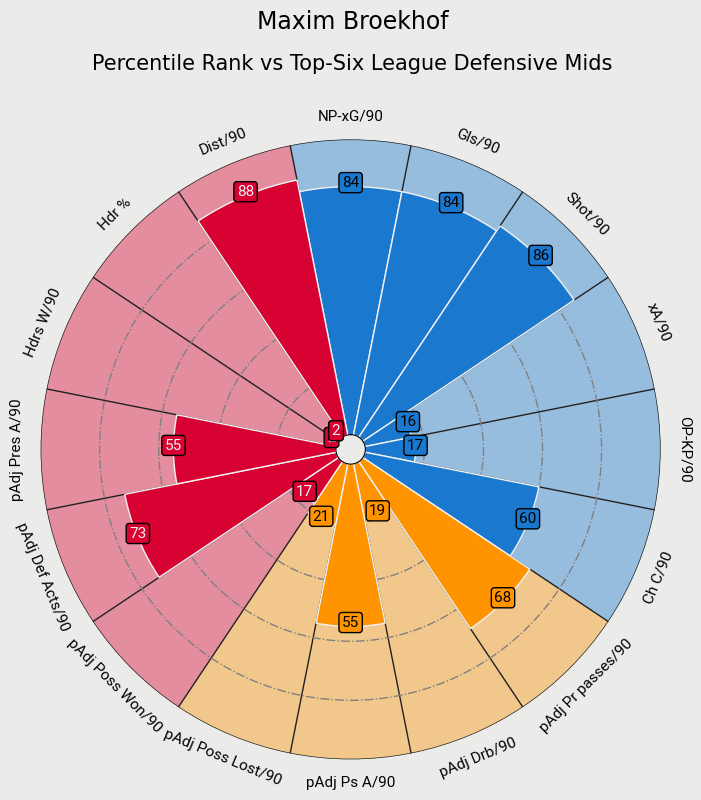

In [23]:
# player_1 = 'Archie Gray'
# player_1 = 'Manu Koné'
player_1 = 'Maxim Broekhof'
# player_1 = 'James Garner'
values = find_percentiles(player_1)

# player_2 = 'Archie Gray'
# player_2 = 'Esteban Fernández'
# player_2 = 'Kal-El Oliveira'
# player_2 = 'Matty Denham'
# player_2 = 'Jayce Fitzgerald'
# player_2 = 'İbrahim Serin'
# player_2 = 'Andi Islami'
player_2 = 'Kobbie Mainoo'
values_2 = find_percentiles(player_2)

font_normal = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Regular.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Italic.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab[wght].ttf')

# color for the slices and text
slice_colors = ["#1A78CF"] * 6 + ["#FF9300"] * 4 + ["#D70232"] * 6
text_colors = ["#000000"] * 10 + ["#F2F2F2"] * 6

# plot pizza
# fig, ax = baker.make_pizza(
#     values,                     # list of values
#     compare_values=values_2,    # comparison values
#     figsize=(8, 8),             # adjust figsize according to your need
#     kwargs_slices=dict(
#         facecolor="#1A78CF", edgecolor="#222222",
#         zorder=2, linewidth=1
#     ),                          # values to be used when plotting slices
#     kwargs_compare=dict(
#         facecolor="#FF9300", edgecolor="#222222",
#         zorder=2, linewidth=1,
#     ),
#     kwargs_params=dict(
#         color="#000000", fontsize=12,
#         fontproperties=font_normal.prop, va="center"
#     ),                          # values to be used when adding parameter
#     kwargs_values=dict(
#         color="#000000", fontsize=12,
#         fontproperties=font_normal.prop, zorder=3,
#         bbox=dict(
#             edgecolor="#000000", facecolor="cornflowerblue",
#             boxstyle="round,pad=0.2", lw=1
#         )
#     ),                          # values to be used when adding parameter-values labels
#     kwargs_compare_values=dict(
#         color="#000000", fontsize=12, fontproperties=font_normal.prop, zorder=3,
#         bbox=dict(edgecolor="#000000", facecolor="#FF9300", boxstyle="round,pad=0.2", lw=1)
#     ),                          # values to be used when adding parameter-values labels
# )

fig, ax = baker.make_pizza(
    values,                          # list of values
    figsize=(8, 8.5),                # adjust figsize according to your need
    color_blank_space="same",        # use same color to fill blank space
    slice_colors=slice_colors,       # color for individual slices
    value_colors=text_colors,        # color for the value-text
    value_bck_colors=slice_colors,   # color for the blank spaces
    blank_alpha=0.4,                 # alpha for blank-space colors
    kwargs_slices=dict(
        edgecolor="#F2F2F2", zorder=2, linewidth=1
    ),                               # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=11,
        fontproperties=font_normal.prop, va="center"
    ),                               # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=11,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                                # values to be used when adding parameter-values
)

# add title
# fig_text(
#     0.515, 0.99, f"<{player_1}> vs <{player_2}>", size=17, fig=fig,
#     highlight_textprops=[{"color": '#1A78CF'}, {"color": '#EE8900'}],
#     ha="center", fontproperties=font_bold.prop, color="#000000"
# )

# add title 
fig.text(
      0.515, 0.99, player_1, size=17,
      ha="center", color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Percentile Rank vs Top-Six League Defensive Mids",
    size=15,
    ha="center", color="#000000"
)


plt.show()

In [24]:
valid_cdms[valid_cdms['Club'] == 'Sevilla']

,Name,Age,Weight,Height,Nat,Preferred Foot,Position,Club,Division,Salary,...,Team Poss,Tck A/90,Def Acts/90,pAdj Pr passes/90,pAdj Drb/90,pAdj Ps A/90,pAdj Poss Lost/90,pAdj Poss Won/90,pAdj Def Acts/90,pAdj Pres A/90
19,David Luque,24,69,174,ESP,Left,"DM, M (LC), AM (C)",Sevilla,Spanish First Division,51000.0,...,0.56,2.49,4.99,3.87,1.00,45.41,7.34,14.69,5.67,13.17
149,Daniel Bragança,32,71,177,POR,Left,"DM, M (C)",Sevilla,Spanish First Division,39500.0,...,0.56,3.13,5.68,4.80,0.37,46.12,7.83,13.51,6.45,11.42
175,Anton Stach,33,84,193,GER,Right,"DM, M/AM (C)",Sevilla,Spanish First Division,42000.0,...,0.56,2.62,6.04,3.87,0.93,45.43,10.71,15.24,6.86,13.01
235,Kobbie Mainoo,27,70,181,ENG,Right,"DM, M (RC), AM (C)",Sevilla,Spanish First Division,29500.0,...,0.56,2.74,5.73,3.65,1.92,40.06,8.59,12.36,6.51,13.47


In [25]:
# valid_cdms['Poss Won/90'].sort_values()

display(valid_cdms[valid_cdms['Name'] == 'Archie Gray'][['Name'] + params])
display(valid_cdms[valid_cdms['Name'] == 'Manu Koné'][['Name'] + params])
display(valid_cdms[valid_cdms['Name'] == 'James Garner'][['Name'] + params])

np.percentile(valid_cdms['Poss Won/90'], 30)

,Name,NP-xG/90,Gls/90,Shot/90,xA/90,OP-KP/90,Ch C/90,pAdj Pr passes/90,pAdj Drb/90,pAdj Ps A/90,pAdj Poss Lost/90,pAdj Poss Won/90,pAdj Def Acts/90,pAdj Pres A/90,Hdrs W/90,Hdr %,Dist/90
1,Archie Gray,0.11,0.13,1.02,0.16,0.96,1.24,4.01,1.01,44.92,4.71,18.69,6.79,12.86,1.93,0.53,8.14


,Name,NP-xG/90,Gls/90,Shot/90,xA/90,OP-KP/90,Ch C/90,pAdj Pr passes/90,pAdj Drb/90,pAdj Ps A/90,pAdj Poss Lost/90,pAdj Poss Won/90,pAdj Def Acts/90,pAdj Pres A/90,Hdrs W/90,Hdr %,Dist/90
101,Manu Koné,0.12,0.05,0.91,0.2,1.65,2.43,3.88,1.89,48.4,7.42,10.2,8.31,11.32,1.81,0.52,8.72


,Name,NP-xG/90,Gls/90,Shot/90,xA/90,OP-KP/90,Ch C/90,pAdj Pr passes/90,pAdj Drb/90,pAdj Ps A/90,pAdj Poss Lost/90,pAdj Poss Won/90,pAdj Def Acts/90,pAdj Pres A/90,Hdrs W/90,Hdr %,Dist/90
337,James Garner,0.07,0.13,1.44,0.18,1.26,1.38,6.66,0.58,55.17,7.25,11.07,6.43,12.09,1.54,0.51,8.43


np.float64(10.172)

In [30]:
def createPizza(player_name):

    # values = valid_cdms[valid_cdms['Name'] == player_name][params]
    values = find_percentiles(player_name)

    baker = PyPizza(
        params=params,                  # list of parameters
        background_color="#EBEBE9",     # background color
        straight_line_color="#222222",  # color for straight lines
        straight_line_lw=1,             # linewidth for straight lines
        last_circle_lw=1,               # linewidth of last circle
        last_circle_color="#222222",    # color of last circle
        other_circle_ls="-.",           # linestyle for other circles
        other_circle_lw=1               # linewidth for other circles
    )

    fig, ax = baker.make_pizza(
        values,                          # list of values
        figsize=(8, 8.5),                # adjust figsize according to your need
        color_blank_space="same",        # use same color to fill blank space
        slice_colors=slice_colors,       # color for individual slices
        value_colors=text_colors,        # color for the value-text
        value_bck_colors=slice_colors,   # color for the blank spaces
        blank_alpha=0.4,                 # alpha for blank-space colors
        kwargs_slices=dict(
            edgecolor="#F2F2F2", zorder=2, linewidth=1
        ),                               # values to be used when plotting slices
        kwargs_params=dict(
            color="#000000", fontsize=11,
            fontproperties=font_normal.prop, va="center"
        ),                               # values to be used when adding parameter
        kwargs_values=dict(
            color="#000000", fontsize=11,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", facecolor="cornflowerblue",
                boxstyle="round,pad=0.2", lw=1
            )
        )                                # values to be used when adding parameter-values
    )

    fig.text(
      0.515, 0.99, player_name, size=17,
      ha="center", color="#000000"
    )
    
    # add subtitle
    fig.text(
        0.515, 0.942,
        "Percentile Rank vs Top-Six League Defensive Mids",
        size=15,
        ha="center", color="#000000"
    )
    
    plt.show()
    
widgets.interact(createPizza, player_name=cdm_names);

interactive(children=(Dropdown(description='player_name', options=('Abdullah Hekmat', 'Achraf el Bouchataoui',…

In [36]:
cdm_names = valid_cdms['Name'].sort_values()

def create_compare_pizza(player_1, player_2):

    values_1 = find_percentiles(player_1)
    values_2 = find_percentiles(player_2)
    
    # plot pizza
    fig, ax = baker.make_pizza(
        values_1,                    # list of values
        compare_values=values_2,    # comparison values
        figsize=(8, 8),             # adjust figsize according to your need
        kwargs_slices=dict(
            facecolor="#1A78CF", edgecolor="#222222",
            zorder=2, linewidth=1
        ),                          # values to be used when plotting slices
        kwargs_compare=dict(
            facecolor="#FF9300", edgecolor="#222222",
            zorder=2, linewidth=1,
        ),
        kwargs_params=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, va="center"
        ),                          # values to be used when adding parameter
        kwargs_values=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", facecolor="cornflowerblue",
                boxstyle="round,pad=0.2", lw=1
            )
        ),                          # values to be used when adding parameter-values labels
        kwargs_compare_values=dict(
            color="#000000", fontsize=12, fontproperties=font_normal.prop, zorder=3,
            bbox=dict(edgecolor="#000000", facecolor="#FF9300", boxstyle="round,pad=0.2", lw=1)
        ),                          # values to be used when adding parameter-values labels
    )

    # add title
    fig_text(
        0.515, 0.99, f"<{player_1}> vs <{player_2}>", size=17, fig=fig,
        highlight_textprops=[{"color": '#1A78CF'}, {"color": '#EE8900'}],
        ha="center", fontproperties=font_bold.prop, color="#000000"
    )
    
    # add subtitle
    fig.text(
        0.515, 0.942,
        "Percentile Rank vs Top-Six League Defensive Mids",
        size=12,
        ha="center", color="#000000"
    )

    plt.show()

    display(valid_cdms[(valid_cdms['Name'] == player_1) | (valid_cdms['Name'] == player_2)][['Name'] + params])

widgets.interact(create_compare_pizza, player_1=cdm_names, player_2=cdm_names);

interactive(children=(Dropdown(description='player_1', options=('Abdullah Hekmat', 'Achraf el Bouchataoui', 'A…

In [93]:
# Players search

# kone_percentiles = find_percentiles('Manu Koné')
# print('Percentiles:')
# for i in range(len(params)):
#     print(f'{params[i]}: {kone_percentiles[i]}th')

metrics = params.copy()
# kone_stats = valid_cdms[valid_cdms['Name'] == 'Manu Koné'].iloc[0]
kone_percentiles = np.array(find_percentiles('Manu Koné'))
# print('Percentiles:')
# for i in range(len(params)):
#     print(f'{params[i]}: {kone_percentiles[i]}th')

# lower-bound: within -10 percentile of Kone stats
lower_bound_percentiles = kone_percentiles - 15
# lower_bound_percentiles

threshold = 11

lower_bound_stats = []
for i in range(len(metrics)):
    lower_bound_stats.append(np.percentile(valid_cdms[metrics[i]], lower_bound_percentiles[i]))

# comparison = valid_cdms[valid_cdms[params].ge(lower_bound_percentiles, axis=1)]
comparison = valid_cdms[metrics].ge(lower_bound_stats, axis=1)

# valid_cdms['Comparison'] = comparison.sum(axis=1)

# display(valid_cdms[['Name', 'Comparison']])


# parse transfer value (based, top value)


# Filter rows where the number of True values is greater than or equal to the threshold
rows_higher_than_reference = valid_cdms[(comparison.sum(axis=1) >= threshold) & (valid_cdms['Age'] <= 28) & (valid_cdms['Hdr %'] > 0.5)]
rows_higher_than_reference[['Name', 'Age', 'Club', 'Transfer Value']]

,Name,Age,Club,Transfer Value
1,Archie Gray,26,FC Bayern,£77M - £95M
13,Hasan Özer,22,Chelsea,£63M - £76M
16,Kal-El Oliveira,24,Leeds,£46M - £58M
17,Gabriel Moscardo,26,Man UFC,£118M - £143M
18,Matty Denham,23,Sunderland,£54M
28,Jayce Fitzgerald,25,Sunderland,£33M - £48M
31,Silvano Vos,27,PSV,£15M - £18.5M
108,Andy Diouf,28,Reims,£21M - £26M
187,Lesley Ugochukwu,28,A. Madrid,£19.5M - £29M
189,Hugo Larsson,27,Juventus,£182M - £218M


short-listed players:
- Archie Gray
- Hasan Ozer
- Kal-El Oliveira
- Matty Denham
- Jayce Fitzgerald
- Silvano Vos
- Lesley Ugochukwu
- Jordan James
- Kobbie Mainoo